# Exploratory data analysis 1

This notebook demonstrates that the ground truth turning angles tend to have more extreme values with higher speeds and with manual driving.

In [2]:
% load_ext autoreload
% autoreload 2
import os

# do we have the correct env loaded?
assert 'donkey2' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

In [14]:
import numpy as np

fast_manual_gt = np.load(
    'open-loop-results/daytime-manual-fast-3d-model-daytime-fast-data-prediction-and-ground-truth.npy')[:, 2]
slow_manual_gt = np.load(
    'open-loop-results/daytime-manual-slow-3d-model-daytime-slow-data-prediction-and-ground-truth.npy')[:, 2]

fast_auto_gt = np.load(
    'open-loop-results/nighttime-fast-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.npy')[:, 2]
slow_auto_gt = np.load(
    'open-loop-results/nighttime-slow-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.npy')[:, 2]

np.concatenate((fast_manual_gt, slow_manual_gt)).shape, np.concatenate((fast_auto_gt, slow_auto_gt)).shape

((52132,), (39554,))

## Demonstrate that fast driving has more extreme ground truth turning angles


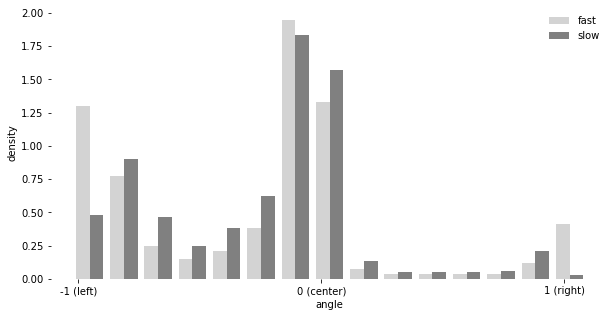

In [25]:
from matplotlib import pyplot as plt


def plot_all(name, ground_truths, colors=('lightgrey', 'grey')):
    fig, ax = plt.subplots(figsize=(10, 5))
    hist, bins, _ = ax.hist(ground_truths.values(), bins=15, density=True, stacked=False, color=colors)
    ax.legend(ground_truths.keys(), frameon=False)
    plt.xlabel('angle')
    plt.ylabel('density')
    plt.xticks([-1, 0, 1], ['-1 (left)', '0 (center)', '1 (right)'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()
    return hist


#
#
# ax.plot(fast, label='fast', c='lightgrey')
# ax.plot(slow, label='slow', c='grey')
#
# ax.text(length + 100, fast.mean() + 10, f'fast data mean: {fast.mean():.1f}', ha='left', va='center')
# ax.hlines(fast.mean(), 0, length, colors='lightgrey', zorder=999)
#
# ax.text(length + 100, slow.mean() - 10, f'slow data mean: {slow.mean():.1f}', ha='left', va='center')
# ax.hlines(slow.mean(), 0, length, colors='lightgrey', zorder=999)
#
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
#
# ax.set_xlabel('frame pixel difference (MSE) with the next frame')
# ax.set_ylabel('frame number')
# ax.set_ylim(0, 500)
# ax.legend(frameon=False)

hist = plot_all('Fast driving has more extreme ground truth turning angles than slow driving',
                dict(fast=fast_auto_gt, slow=slow_auto_gt))


## Demonstrate that manual driving has more extreme ground truth turning angles

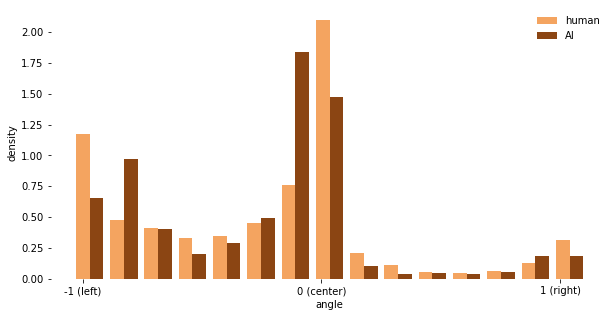

In [26]:

hist = plot_all('Human driving has more extreme ground truth turning angles than AI driving',
                dict(
                    human=np.concatenate((fast_manual_gt, slow_manual_gt)),
                    AI=np.concatenate((fast_auto_gt, slow_auto_gt))),
                colors=('sandybrown', 'saddlebrown'))